In [ ]:
# Ispirato dal video https://www.youtube.com/watch?v=6clmthGECvc&t=0s

# Metodo 1

## Importazione librerie

In [4]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

## Download dati

In [2]:
# Inizializza l'exchange
exchange = ccxt.binance()

# Definisci il simbolo e il timeframe desiderato
symbol = 'BTC/USDT'
timeframe = '1d'  # Timeframe giornaliero

# Calcola la data di inizio (ad esempio, 365 giorni fa)
since = exchange.parse8601((datetime.now() - timedelta(days=365)).strftime('%Y-%m-%dT%H:%M:%S'))

# Scarica i dati storici
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Crea un DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

df.head()

,open,high,low,close,volume
timestamp,,,,,
2023-11-26,37780.67,37814.63,37150.00,37447.43,21264.53723
2023-11-27,37447.42,37569.23,36707.00,37242.70,30001.07376
2023-11-28,37242.70,38377.00,36868.41,37818.87,37544.46667
2023-11-29,37818.88,38450.00,37570.00,37854.64,32994.19107
2023-11-30,37854.65,38145.85,37500.00,37723.96,24740.29147


## Analisi ciclica

Frequenze dominanti (cicli/giorno): [0.00273973 0.00821918 0.00547945]
Periodi dominanti (giorni): [365.         121.66666667 182.5       ]


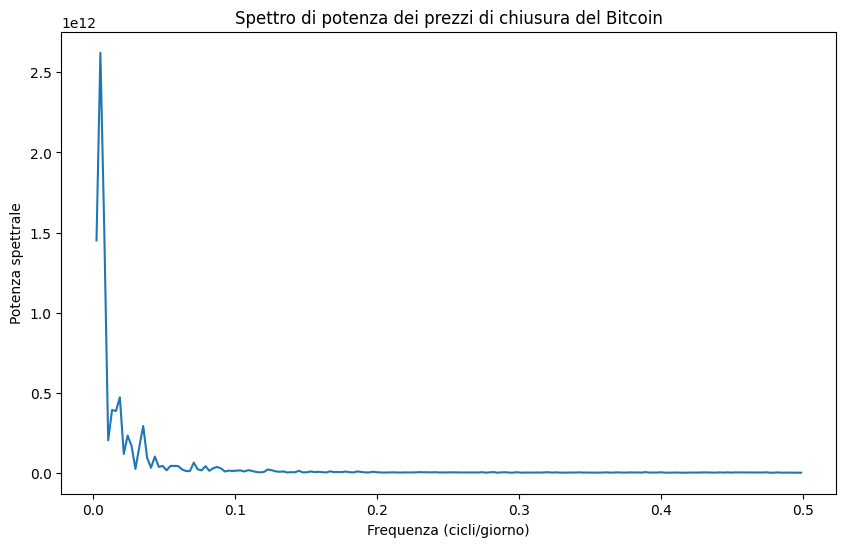

In [5]:
# Estrai i prezzi di chiusura
close_prices = df['close'].values

# Calcola la media e sottraila dai prezzi per rimuovere la componente DC
close_prices_detrended = close_prices - np.mean(close_prices)

# Applica la Trasformata di Fourier
fft_result = np.fft.fft(close_prices_detrended)
fft_freq = np.fft.fftfreq(len(fft_result))

# Calcola la potenza spettrale
power_spectrum = np.abs(fft_result)**2

# Filtra le frequenze positive
positive_freqs = fft_freq > 0
freqs = fft_freq[positive_freqs]
power = power_spectrum[positive_freqs]

# Identifica le frequenze dominanti
dominant_freqs = freqs[np.argsort(power)[-3:]]  # Le 3 frequenze con potenza maggiore
dominant_periods = 1 / dominant_freqs

print("Frequenze dominanti (cicli/giorno):", dominant_freqs)
print("Periodi dominanti (giorni):", dominant_periods)

# Visualizza lo spettro di potenza
plt.figure(figsize=(10, 6))
plt.plot(freqs, power)
plt.xlabel('Frequenza (cicli/giorno)')
plt.ylabel('Potenza spettrale')
plt.title('Spettro di potenza dei prezzi di chiusura del Bitcoin')
plt.show()

## Generazione dei segnali di trading

In [6]:
# Seleziona la frequenza dominante principale
dominant_freq = dominant_freqs[np.argmax(power)]

# Calcola il periodo dominante
dominant_period = int(1 / dominant_freq)

# Crea un indicatore sinusoidale basato sul periodo dominante
t = np.arange(len(close_prices))
sinusoid = np.sin(2 * np.pi * dominant_freq * t)

# Normalizza l'indicatore
sinusoid_normalized = (sinusoid - np.min(sinusoid)) / (np.max(sinusoid) - np.min(sinusoid))

# Aggiungi l'indicatore al DataFrame
df['sinusoid_indicator'] = sinusoid_normalized

# Genera segnali di acquisto e vendita
df['signal'] = 0
df.loc[df['sinusoid_indicator'] < 0.2, 'signal'] = 1  # Segnale di acquisto
df.loc[df['sinusoid_indicator'] > 0.8, 'signal'] = -1  # Segnale di vendita

print(df[['close', 'sinusoid_indicator', 'signal']].tail())

               close  sinusoid_indicator  signal
timestamp                                       
2024-11-20  94286.56            0.372322       0
2024-11-21  98317.12            0.397447       0
2024-11-22  98892.00            0.422845       0
2024-11-23  97672.40            0.448449       0
2024-11-24  95963.13            0.474190       0


## Implementazione del sistema di trading

In [ ]:
# def execute_trade(signal, symbol, amount):
#     if signal == 1:
#         # Esegui ordine di acquisto
#         order = exchange.create_market_buy_order(symbol, amount)
#         print(f"Acquistato {amount} di {symbol}")
#     elif signal == -1:
#         pass

# Metodo 2

## Importazione librerie

In [ ]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

## Download dati

In [8]:
# Inizializza l'exchange Binance
exchange = ccxt.binance()

# Definisci il simbolo e il timeframe
symbol = 'BTC/USDT'
timeframe = '1d'  # Timeframe giornaliero

# Definisci il numero di candele da scaricare
limit = 1000

# Scarica i dati OHLCV
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)

# Crea un DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# Converti il timestamp in formato datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Imposta il timestamp come indice
df.set_index('timestamp', inplace=True)

## Analisi ciclica

In [9]:
# Calcola la Trasformata di Fourier
fft = np.fft.fft(df['close'])
frequencies = np.fft.fftfreq(len(fft))

# Calcola la potenza spettrale
power = np.abs(fft)**2

# Filtra le frequenze positive
positive_frequencies = frequencies[frequencies > 0]
positive_power = power[frequencies > 0]

# Identifica la frequenza dominante
dominant_frequency = positive_frequencies[np.argmax(positive_power)]
dominant_period = 1 / dominant_frequency

print(f'Periodo dominante: {dominant_period} giorni')

Periodo dominante: 1000.0 giorni


## Identificazione dei minimi e massimi locali

In [10]:
# Definisci il filtro passa-basso
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Applica il filtro
cutoff = 1 / dominant_period  # Frequenza di taglio
fs = 1  # Frequenza di campionamento (1 giorno)
order = 2

b, a = butter_lowpass(cutoff, fs, order)
df['filtered'] = filtfilt(b, a, df['close'])

# Identifica minimi e massimi locali
df['min_local'] = (df['filtered'].shift(1) > df['filtered']) & (df['filtered'].shift(-1) > df['filtered'])
df['max_local'] = (df['filtered'].shift(1) < df['filtered']) & (df['filtered'].shift(-1) < df['filtered'])

## Generazione dei segnali di trading

In [11]:
df['signal'] = 0
df.loc[df['min_local'], 'signal'] = 1  # Segnale di acquisto
df.loc[df['max_local'], 'signal'] = -1  # Segnale di vendita

## Visualizzazione dei risultati

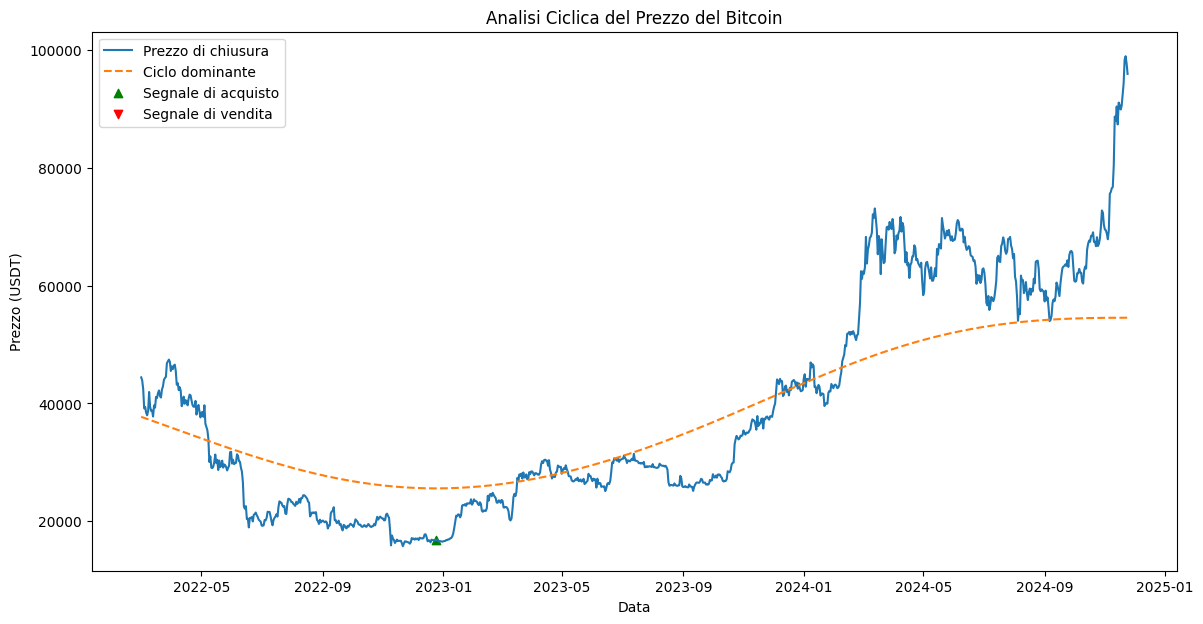

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Prezzo di chiusura')
plt.plot(df.index, df['filtered'], label='Ciclo dominante', linestyle='--')
plt.scatter(df.index[df['signal'] == 1], df['close'][df['signal'] == 1], marker='^', color='g', label='Segnale di acquisto')
plt.scatter(df.index[df['signal'] == -1], df['close'][df['signal'] == -1], marker='v', color='r', label='Segnale di vendita')
plt.legend()
plt.title('Analisi Ciclica del Prezzo del Bitcoin')
plt.xlabel('Data')
plt.ylabel('Prezzo (USDT)')
plt.show()

# Metodo 3

In [1]:
import time
import ccxt
import pandas as pd

def download_and_plot(cryptos, timeframe, start_date, end_date, plot):
    
    exchange = ccxt.binance()  # Usa Binance come exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{cryptos[0]} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [2]:
# Periodo personale
data_inizio = '2014-01-01'
data_fine = '2024-11-01'

chosen_cryptos = ['BTC']
timeframe_download = '1d'

data_frames = download_and_plot(chosen_cryptos, timeframe_download, data_inizio, data_fine, plot=False)

# Prepara il DataFrame `crypto_prices` con timestamp e prezzi di chiusura
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[chosen_cryptos[0]].index
for crypto in chosen_cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values

Scarico i dati per BTC/USDT dal 2014-01-01 al 2024-11-01...


In [3]:
data = data_frames['BTC']
data

,open,high,low,close,volume
timestamp,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2024-10-28,68021.69,70270.00,67618.00,69962.21,29046.754590
2024-10-29,69962.21,73620.12,69760.00,72736.42,50128.605940
2024-10-30,72736.41,72961.00,71436.00,72344.74,26885.990560


In [4]:
# Aggiunge un filtro passa-basso ai dati per ridurre il rumore
from scipy.signal import butter, filtfilt

def smooth_data(data, cutoff=0.05, order=2):
    b, a = butter(order, cutoff, btype='low', analog=False)
    data['smoothed'] = filtfilt(b, a, data['close'])
    return data

# Applica il filtro
data = smooth_data(data)
data

,open,high,low,close,volume,smoothed
timestamp,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,4321.606571
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,4323.447108
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,4325.916917
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,4329.270242
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,4333.634644
...,...,...,...,...,...,...
2024-10-28,68021.69,70270.00,67618.00,69962.21,29046.754590,68779.585487
2024-10-29,69962.21,73620.12,69760.00,72736.42,50128.605940,68925.825123
2024-10-30,72736.41,72961.00,71436.00,72344.74,26885.990560,69050.906035


In [5]:
from scipy.signal import argrelextrema
import numpy as np

# Trova i minimi e massimi locali
def identify_cycles(data, window=5):
    data['min_local'] = data['close'] == data['close'].rolling(window, center=True).min()
    data['max_local'] = data['close'] == data['close'].rolling(window, center=True).max()
    return data

# Identifica i cicli
data = identify_cycles(data, window=10)
data[['close', 'min_local', 'max_local']]

,close,min_local,max_local
timestamp,,,
2017-08-17,4285.08,False,False
2017-08-18,4108.37,False,False
2017-08-19,4139.98,False,False
2017-08-20,4086.29,False,False
2017-08-21,4016.00,False,False
...,...,...,...
2024-10-28,69962.21,False,False
2024-10-29,72736.42,False,False
2024-10-30,72344.74,False,False


In [6]:
def analyze_cycles(data, cycle_min, cycle_max):
    cycles = []
    current_cycle = {'start': None, 'end': None, 'type': None}
    
    for i in range(len(data)):
        if data['min_local'].iloc[i]:
            if current_cycle['start'] is None:
                current_cycle['start'] = data.index[i]
            else:
                current_cycle['end'] = data.index[i]
                duration = (current_cycle['end'] - current_cycle['start']).days
                
                # Verifica il vincolo ciclico
                if duration < cycle_min:
                    current_cycle['type'] = 'invalid (too short)'
                elif duration > cycle_max:
                    current_cycle['type'] = 'invalid (too long)'
                else:
                    current_cycle['type'] = 'valid'
                
                cycles.append(current_cycle)
                current_cycle = {'start': data.index[i], 'end': None, 'type': None}
    return cycles

# Analizza i cicli aggiornati
cycles = analyze_cycles(data, cycle_min=20, cycle_max=50)
cycles

[{'start': Timestamp('2017-09-04 00:00:00'),
  'end': Timestamp('2017-09-14 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-09-14 00:00:00'),
  'end': Timestamp('2017-09-22 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-09-22 00:00:00'),
  'end': Timestamp('2017-10-18 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-10-18 00:00:00'),
  'end': Timestamp('2017-10-24 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-10-24 00:00:00'),
  'end': Timestamp('2017-11-12 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-11-12 00:00:00'),
  'end': Timestamp('2017-12-23 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-12-23 00:00:00'),
  'end': Timestamp('2017-12-30 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2017-12-30 00:00:00'),
  'end': Timestamp('2018-01-11 00:00:00'),
  'type': 'invalid (too short)'},
 {'start': Timestamp('2018-01-11 00:00:00'),
  'end'

In [7]:
def generate_signals(data, cycles):
    data['signal'] = 0
    for cycle in cycles:
        if cycle['type'] == 'valid':
            data.loc[cycle['start'], 'signal'] = 1  # Compra
            if cycle['end'] is not None:
                data.loc[cycle['end'], 'signal'] = -1  # Vendi
    return data

# Genera i segnali
data = generate_signals(data, cycles)
data[['close', 'signal']]

,close,signal
timestamp,,
2017-08-17,4285.08,0
2017-08-18,4108.37,0
2017-08-19,4139.98,0
2017-08-20,4086.29,0
2017-08-21,4016.00,0
...,...,...
2024-10-28,69962.21,0
2024-10-29,72736.42,0
2024-10-30,72344.74,0


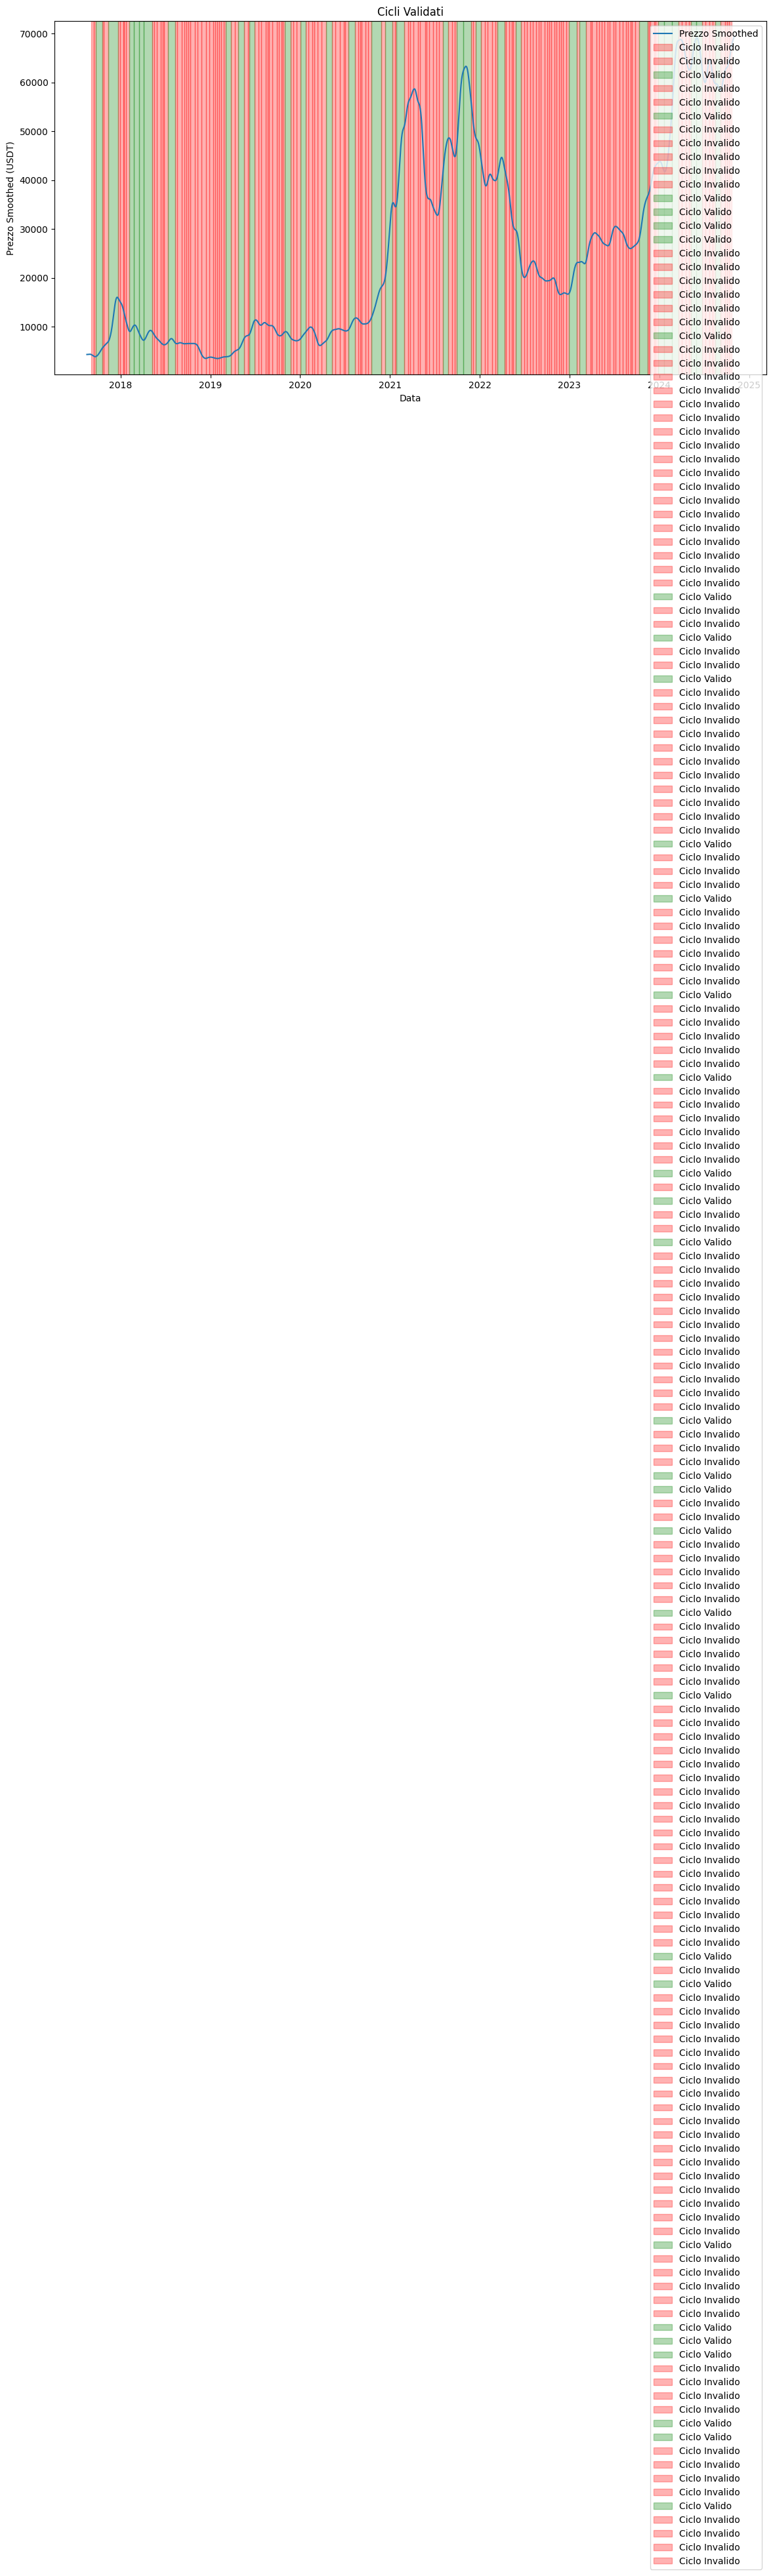

In [9]:
import matplotlib.pyplot as plt

def plot_cycles(data, cycles):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['smoothed'], label='Prezzo Smoothed')
    for cycle in cycles:
        if cycle['type'] == 'valid':
            plt.axvspan(cycle['start'], cycle['end'], color='green', alpha=0.3, label='Ciclo Valido')
        else:
            plt.axvspan(cycle['start'], cycle['end'], color='red', alpha=0.3, label='Ciclo Invalido')
    plt.legend()
    plt.title('Cicli Validati')
    plt.xlabel('Data')
    plt.ylabel('Prezzo Smoothed (USDT)')
    plt.show()

# Visualizza i cicli
plot_cycles(data, cycles)

In [10]:
# Contiamo il numero di cicli validi e invalidi
valid_cycles = [cycle for cycle in cycles if cycle['type'] == 'valid']
invalid_cycles = [cycle for cycle in cycles if cycle['type'] != 'valid']

print(f"Numero di cicli validi: {len(valid_cycles)}")
print(f"Numero di cicli invalidi: {len(invalid_cycles)}")

Numero di cicli validi: 32
Numero di cicli invalidi: 152


In [11]:
# Calcola la durata media dei cicli
cycle_durations = [(cycle['end'] - cycle['start']).days for cycle in cycles if cycle['end'] is not None]
average_cycle_duration = np.mean(cycle_durations)

# Aggiorna i parametri
cycle_min = max(10, int(average_cycle_duration * 0.5))  # Riduci il minimo
cycle_max = int(average_cycle_duration * 1.5)          # Aumenta il massimo

print(f"Nuovi parametri - Ciclo Min: {cycle_min}, Ciclo Max: {cycle_max}")

Nuovi parametri - Ciclo Min: 10, Ciclo Max: 21


In [13]:
def refine_cycles(data, cycles, tolerance=5):
    refined_cycles = []
    for cycle in cycles:
        if cycle['type'] == 'invalid (too short)' and (cycle['end'] - cycle['start']).days + tolerance >= cycle_min:
            cycle['type'] = 'valid'
        elif cycle['type'] == 'invalid (too long)' and (cycle['end'] - cycle['start']).days - tolerance <= cycle_max:
            cycle['type'] = 'valid'
        refined_cycles.append(cycle)
    return refined_cycles

# Raffina i cicli
cycles = refine_cycles(data, cycles)
cycles

[{'start': Timestamp('2017-09-04 00:00:00'),
  'end': Timestamp('2017-09-14 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-09-14 00:00:00'),
  'end': Timestamp('2017-09-22 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-09-22 00:00:00'),
  'end': Timestamp('2017-10-18 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-10-18 00:00:00'),
  'end': Timestamp('2017-10-24 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-10-24 00:00:00'),
  'end': Timestamp('2017-11-12 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-11-12 00:00:00'),
  'end': Timestamp('2017-12-23 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-12-23 00:00:00'),
  'end': Timestamp('2017-12-30 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-12-30 00:00:00'),
  'end': Timestamp('2018-01-11 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-01-11 00:00:00'),
  'end': Timestamp('2018-01-16 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-0

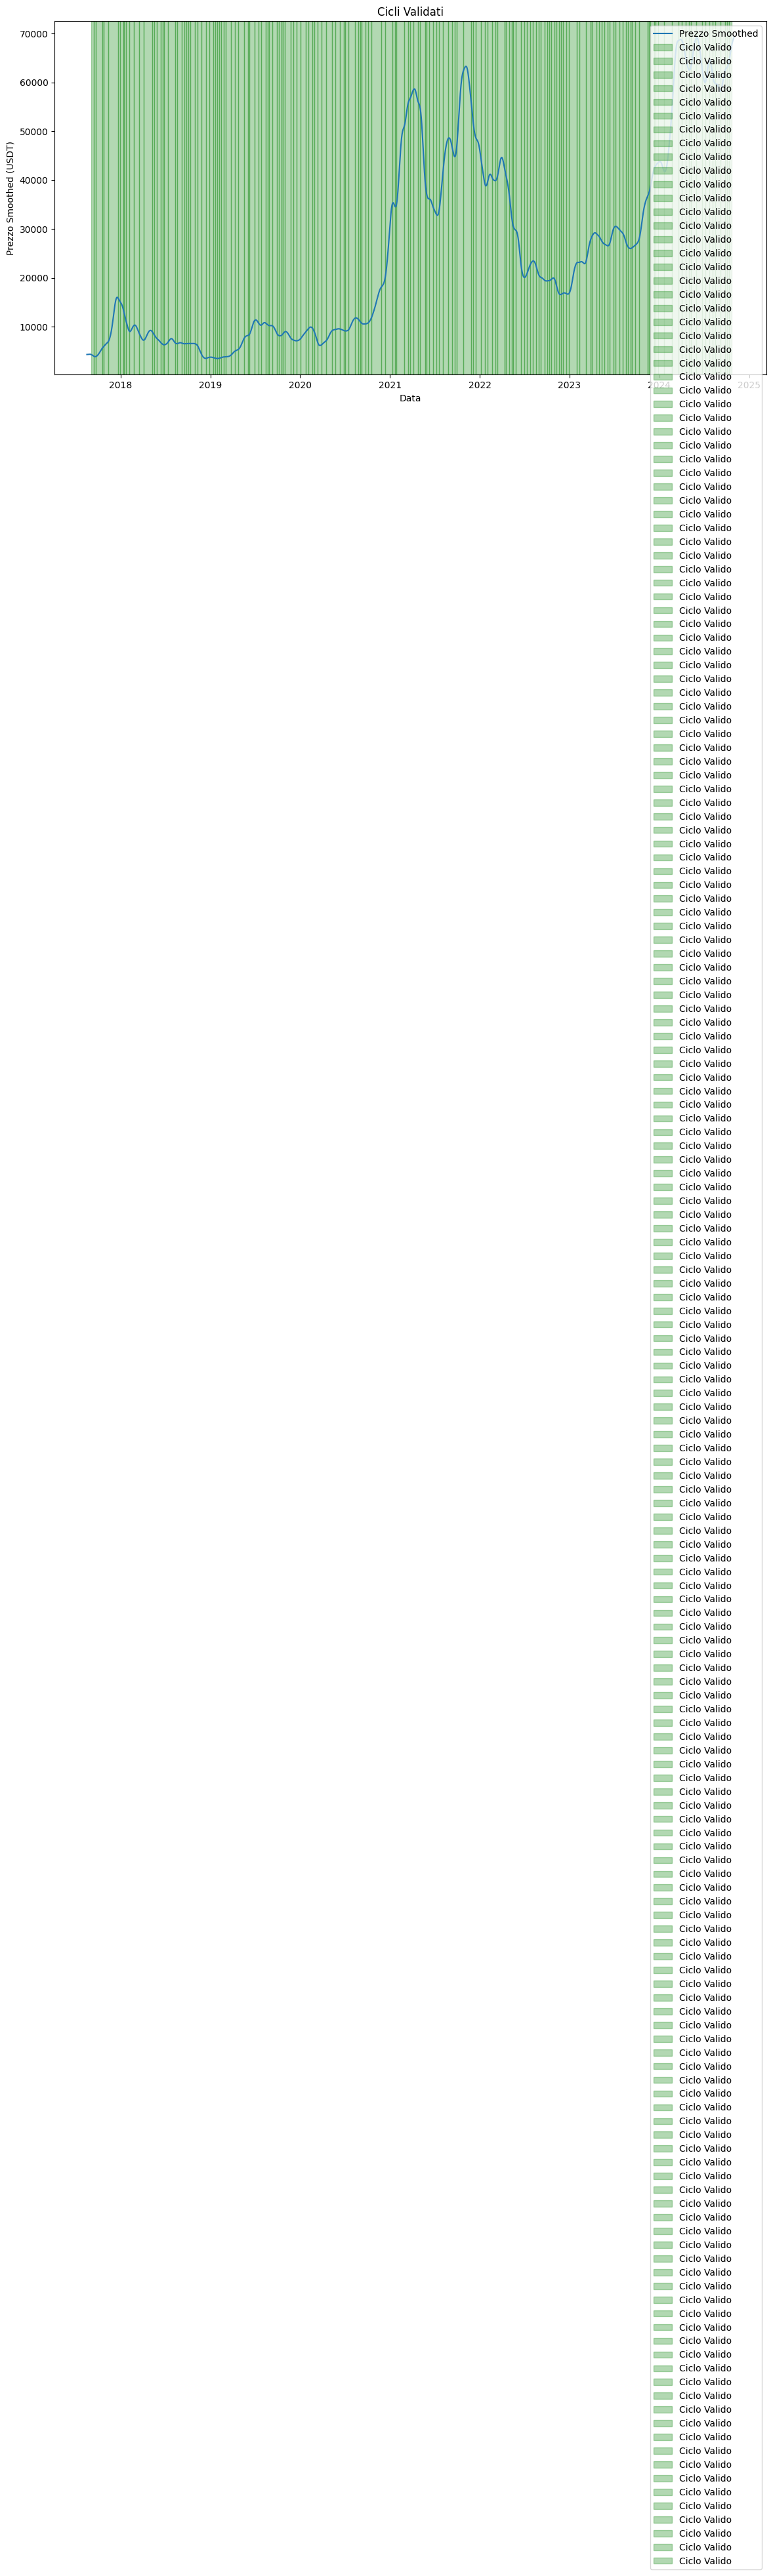

In [14]:
plot_cycles(data, cycles)

In [15]:
def filter_cycles_by_price(data, cycles, min_price_change=5):
    refined_cycles = []
    for cycle in cycles:
        if cycle['type'] == 'valid' and cycle['end'] is not None:
            price_start = data.loc[cycle['start'], 'close']
            price_end = data.loc[cycle['end'], 'close']
            price_change = abs(price_end - price_start) / price_start * 100  # Variazione percentuale
            if price_change >= min_price_change:
                refined_cycles.append(cycle)
    return refined_cycles

# Filtra i cicli validi
cycles = filter_cycles_by_price(data, cycles, min_price_change=10)  # Almeno il 10% di variazione
cycles

[{'start': Timestamp('2017-09-04 00:00:00'),
  'end': Timestamp('2017-09-14 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-09-14 00:00:00'),
  'end': Timestamp('2017-09-22 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-09-22 00:00:00'),
  'end': Timestamp('2017-10-18 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-11-12 00:00:00'),
  'end': Timestamp('2017-12-23 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-01-11 00:00:00'),
  'end': Timestamp('2018-01-16 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-01-22 00:00:00'),
  'end': Timestamp('2018-02-05 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-02-05 00:00:00'),
  'end': Timestamp('2018-02-25 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-02-25 00:00:00'),
  'end': Timestamp('2018-03-17 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-03-17 00:00:00'),
  'end': Timestamp('2018-04-06 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-0

In [16]:
def penalize_frequent_cycles(cycles, min_gap=10):
    refined_cycles = []
    last_end = None
    for cycle in cycles:
        if last_end is None or (cycle['start'] - last_end).days >= min_gap:
            refined_cycles.append(cycle)
        last_end = cycle['end']
    return refined_cycles

# Penalizza i cicli sovrapposti
cycles = penalize_frequent_cycles(cycles, min_gap=15)  # Almeno 15 giorni di distanza tra i cicli
cycles

[{'start': Timestamp('2017-09-04 00:00:00'),
  'end': Timestamp('2017-09-14 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2017-11-12 00:00:00'),
  'end': Timestamp('2017-12-23 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-01-11 00:00:00'),
  'end': Timestamp('2018-01-16 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2018-11-09 00:00:00'),
  'end': Timestamp('2018-11-26 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2019-03-25 00:00:00'),
  'end': Timestamp('2019-04-11 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2019-06-09 00:00:00'),
  'end': Timestamp('2019-07-01 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2019-09-10 00:00:00'),
  'end': Timestamp('2019-09-29 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2019-10-24 00:00:00'),
  'end': Timestamp('2019-10-31 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2020-01-02 00:00:00'),
  'end': Timestamp('2020-01-25 00:00:00'),
  'type': 'valid'},
 {'start': Timestamp('2020-0

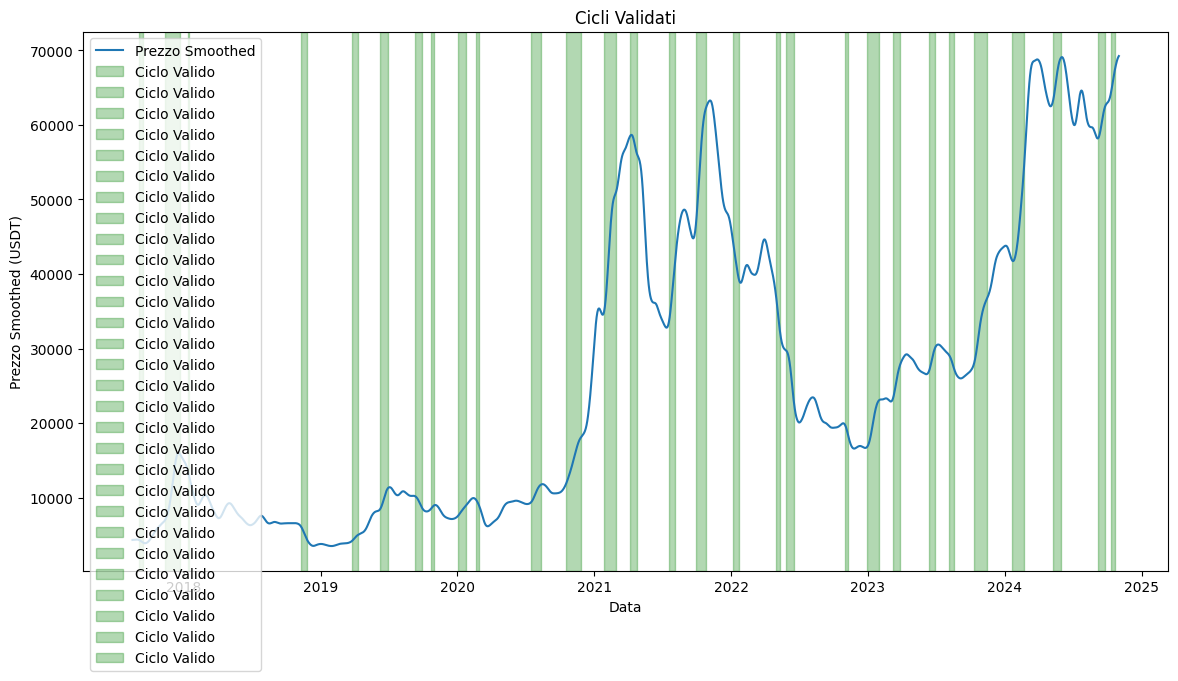

In [17]:
plot_cycles(data, cycles)

In [18]:
def backtest(data):
    balance = 1000  # Capitale iniziale in USDT
    position = 0  # Bitcoin posseduti
    for i in range(len(data)):
        if data['signal'].iloc[i] == 1:  # Compra
            if balance > 0:
                position = balance / data['close'].iloc[i]
                balance = 0
        elif data['signal'].iloc[i] == -1:  # Vendi
            if position > 0:
                balance = position * data['close'].iloc[i]
                position = 0
    # Valore finale (se rimangono Bitcoin non venduti)
    final_balance = balance + (position * data['close'].iloc[-1])
    return final_balance

# Esegui il backtest
final_balance = backtest(data)
print(f"Bilancio finale: {final_balance:.2f} USDT")

Bilancio finale: 125230.99 USDT


In [19]:
def split_data(data, train_days=60, test_days=30):
    total_days = len(data)
    blocks = []
    for start in range(0, total_days - train_days - test_days, test_days):
        train_start = start
        train_end = start + train_days
        test_start = train_end
        test_end = train_end + test_days
        
        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[test_start:test_end]
        blocks.append((train_data, test_data))
    return blocks

# Suddividi i dati in blocchi
blocks = split_data(data, train_days=60, test_days=30)
blocks

[(               open     high      low    close       volume     smoothed  \
  timestamp                                                                  
  2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377  4321.606571   
  2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264  4323.447108   
  2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763  4325.916917   
  2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022  4329.270242   
  2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060  4333.634644   
  2017-08-22  4016.00  4104.82  3400.00  4040.00   966.684858  4338.984753   
  2017-08-23  4040.00  4265.80  4013.89  4114.01  1001.136565  4345.122911   
  2017-08-24  4147.00  4371.68  4085.01  4316.01   787.418753  4351.687735   
  2017-08-25  4316.01  4453.91  4247.48  4280.68   573.612740  4358.198124   
  2017-08-26  4280.71  4367.00  4212.41  4337.44   228.108068  4364.104910   
  2017-08-27  4332.51  4400.00  4285.54  4310.01   350.692585  4